# Cumulative Comovement Sum Example

This example goes over a the Cumulative Sum Co-movement Example not published by Gerber or Hudson Bay Capital but from Capital Fund Management [Bond-equity correlations: An alternative measure
](https://www.cfm.com/bond-equity-correlations-an-alternative-measure/). In this case to measure the stock-bond correlation TLT and SPY ETFs will be used. 

The statistic can mathematically be described as for 2 random vectors of price returns $\vec{X}, \vec{Y} \in \mathbb{R}$

\begin{equation}
\vec{\rho}_{comov} =\left(\frac{\vec{x}}{||\vec{x}||}\right)^{\intercal}  \frac{\vec{y}}{||\vec{y}||}
\end{equation}

## Packages

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

## Access Gerber Object

In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))
from Gerber import Gerber

## Shiller-Cape Data Test

### Collect Data 

In [3]:
link = "http://www.econ.yale.edu/~shiller/data/ie_data.xls"
df_raw = (pd.read_excel(
    io = link,
    sheet_name = "Data",
    skiprows = 6))

col_renamer = {
    "Unnamed: 0": "spx_date",
    "Comp.": "spx_price",
    "Interest": "long_term_rate"}

df_clean = (df_raw.rename(
    columns = col_renamer)
    [list(col_renamer.values())].
    iloc[1:].
    dropna())

df_month = (df_clean.assign(
    month = lambda x: x.spx_date.astype(str).str.split(".").str[1]).
    month.
    drop_duplicates().
    to_frame().
    reset_index().
    rename(columns = {"index": "new_month"}))

In [4]:
df_prep = (df_clean.assign(
    month = lambda x: x.spx_date.astype(str).str.split(".").str[1]).
    merge(right = df_month, how = "inner", on = ["month"]).
    drop(columns = ["month"]).
    assign(
        year_month = lambda x: x.spx_date.astype(str).str.split(".").str[0] + "-" + x.new_month.astype(str),
        date = lambda x: pd.to_datetime(x.year_month, format = "%Y-%m")).
    drop(columns = ["spx_date", "new_month", "year_month"]).
    set_index("date").
    sort_index())

In [5]:
df_input = (df_prep.assign(
    carry = lambda x: x.long_term_rate.shift(1) * 9,
    price_change = lambda x: (x.long_term_rate.shift(1) - x.long_term_rate) * 1_000,
    bond_rtn = lambda x: x.price_change + x.carry,
    spx_rtn = lambda x: x.spx_price.pct_change())
    [["spx_rtn", "bond_rtn"]].
    dropna())

### Find Cumulative Sum Co-Movement

In [9]:
df_cumsum = Gerber().cumsum_comovement(df_input)

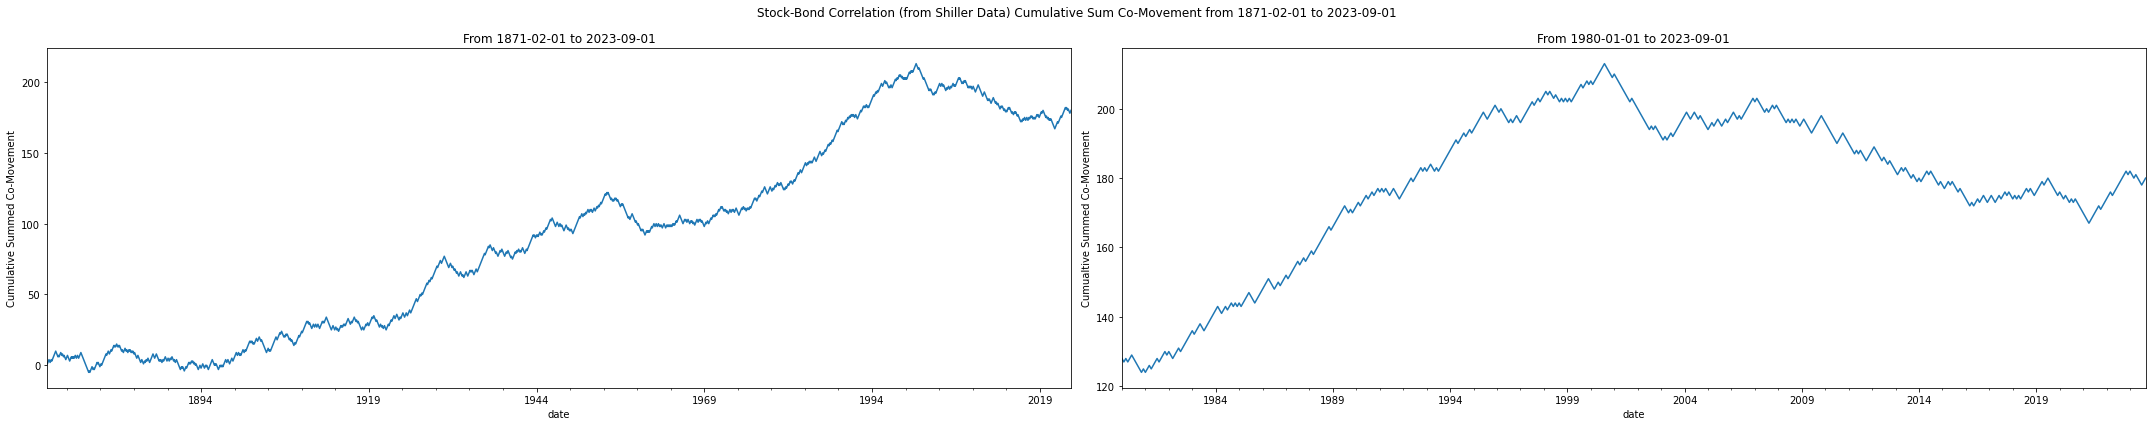

In [18]:
fig, axes = plt.subplots(ncols = 2, figsize = (30,6))

(df_cumsum.plot(
    ax = axes[0],
    legend = False,
    ylabel = "Cumulative Summed Co-Movement",
    title = "From {} to {}".format(
        df_cumsum.index.min().date(),
        df_cumsum.index.max().date())))

(df_cumsum.reset_index().query(
    "date >= '1980-01-01'").
    set_index("date").
    plot(
        ax = axes[1],
        legend = False,
        ylabel = "Cumualtive Summed Co-Movement",
        title = "From 1980-01-01 to {}".format(
            df_cumsum.index.max().date())))

fig.suptitle("Stock-Bond Correlation Monthly Returns (from Shiller Data) Cumulative Sum Co-Movement from {} to {}".format(
    df_cumsum.index.min().date(),
    df_cumsum.index.max().date()))

plt.tight_layout()

## Using TLT and SPY ETFs

In [21]:
end_date = dt.date.today()
start_date = dt.date(year = end_date.year - 30, month = 1, day = 1)
tickers = ["SPY", "TLT"]
df = yf.download(tickers = tickers, start = start_date, end = end_date)["Adj Close"].pct_change().dropna()

[*********************100%***********************]  2 of 2 completed


In [23]:
df_comove = Gerber().cumsum_comovement(df)

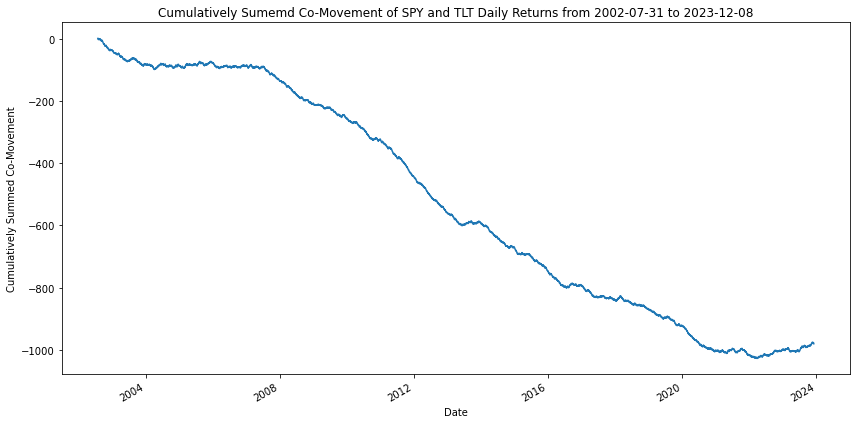

In [27]:
df_comove.plot(
    figsize = (12,6),
    legend = False,
    ylabel = "Cumulatively Summed Co-Movement",
    title = "Cumulatively Sumemd Co-Movement of SPY and TLT Daily Returns from {} to {}".format(
        df.index.min().date(),
        df.index.max().date()))

plt.tight_layout()